# Intel & MobileODT Cervical Cancer Screening

I am working on this project for a Kaggle competition:

https://www.kaggle.com/c/intel-mobileodt-cervical-cancer-screening

My goal is accurately identifie a woman’s cervix type (type 1, type 2 or type 3) based on the image. 
I have 250 images for type 1, 781 images for type 2, and 450 images for type 3 at all.

I created:

**validation set:** 10% of images of every type.

**training set:** one copy of every image of type 2, 2 copy of every image of type 3, and 3 copy of every image of type 1. I am going to use ImageDataGenerator() to transfor the images.  

During the training I realized that when we use CNN, it is very important for classes to be balanced. Otherwise, the algorithm tend to assign the most common class to every image. 

Using preprocessing.py I saved all labels and all images with ressolution 64 by 64 in training_64_dublicated_data.pickle and validation_64.pickle.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [54]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [282]:
with open('training_64_dublicated_data.pickle', 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')

In [283]:
with open('validation_64.pickle', 'rb') as fo:
        validation_data = pickle.load(fo, encoding='bytes')

In [284]:
x = data[b'data']
x = np.array(x)
x = x.reshape(-1,64,64,3)

labels = data[b'labels']

In [285]:
x.shape

(2188, 64, 64, 3)

In [286]:
labels = data[b'labels']

In [287]:
df = pd.DataFrame(data)

### Training / testing data

b'Type_3'    810
b'Type_2'    703
b'Type_1'    675
Name: b'labels', dtype: int64

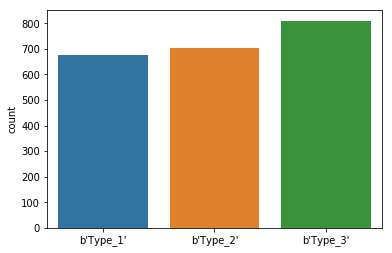

In [288]:
g = sns.countplot(labels)
df[b'labels'].value_counts()

Our classes are balanced now.

In [289]:
x_val = validation_data[b'data']
x_val = np.array(x_val)
x_val = x_val.reshape(-1,64,64,3)

labels_val = validation_data[b'labels']
x_val.shape

(148, 64, 64, 3)

In [290]:
df_val = pd.DataFrame(validation_data)

### Validation Data

b'Type_2'    78
b'Type_3'    45
b'Type_1'    25
Name: b'labels', dtype: int64

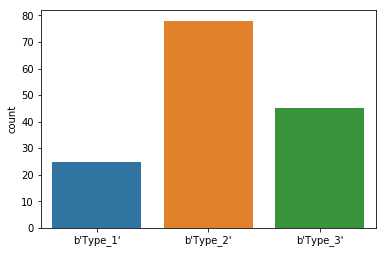

In [291]:
g = sns.countplot(labels_val)
df_val[b'labels'].value_counts()

Our validation set has the same proportion of the images to differen type as all original data. 

### Training Preparation

In [292]:
encoder = LabelEncoder()
encoder.fit(labels)
labels = encoder.transform(labels)

Type_1 is "0", Type_2 is "1", Type_3 is "2"

In [293]:
X_train, X_test, Y_train, Y_test = train_test_split(x, labels, test_size = 0.1, random_state=101)

Testing set: 219 samples (69 - 76 - 74) for type 1, 2, 3

Training set: 1969 samples (606 - 627 - 736)

In [303]:
(Y_train == 2).sum() # type 3

736

In [308]:
nb_train_samples = len(X_train)
nb_validation_samples = len(X_test)

In [309]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [310]:
X_train.shape

(1969, 64, 64, 3)

In [311]:
X_test.shape

(219, 64, 64, 3)

In [312]:
Y_train = to_categorical(Y_train,num_classes=3)
Y_test = to_categorical(Y_test, num_classes=3)

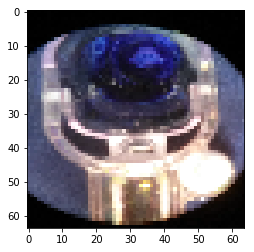

In [313]:
plt.imshow(X_train[400])

An interesting article how to chose the number of filters and layers for CNN:

http://www.cognitivescientist.net/papers/AI2014_Chu_Krzyzak.pdf

In [314]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))



model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation = "sigmoid"))

In [255]:
'''
[<tf.Tensor 'conv2d_67/Relu:0' shape=(?, 64, 64, 8) dtype=float32>,
 <tf.Tensor 'max_pooling2d_67/MaxPool:0' shape=(?, 32, 32, 8) dtype=float32>,
 <tf.Tensor 'conv2d_68/Relu:0' shape=(?, 32, 32, 16) dtype=float32>,
 <tf.Tensor 'max_pooling2d_68/MaxPool:0' shape=(?, 16, 16, 16) dtype=float32>,
 <tf.Tensor 'conv2d_69/Relu:0' shape=(?, 16, 16, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_69/MaxPool:0' shape=(?, 8, 8, 32) dtype=float32>,
 <tf.Tensor 'dropout_45/cond/Merge:0' shape=(?, 8, 8, 32) dtype=float32>,
 <tf.Tensor 'flatten_13/Reshape:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'dense_45/Relu:0' shape=(?, 32) dtype=float32>,
 <tf.Tensor 'dropout_46/cond/Merge:0' shape=(?, 32) dtype=float32>,
 <tf.Tensor 'dense_46/Sigmoid:0' shape=(?, 3) dtype=float32>]

'''

"\n[<tf.Tensor 'conv2d_67/Relu:0' shape=(?, 64, 64, 8) dtype=float32>,\n <tf.Tensor 'max_pooling2d_67/MaxPool:0' shape=(?, 32, 32, 8) dtype=float32>,\n <tf.Tensor 'conv2d_68/Relu:0' shape=(?, 32, 32, 16) dtype=float32>,\n <tf.Tensor 'max_pooling2d_68/MaxPool:0' shape=(?, 16, 16, 16) dtype=float32>,\n <tf.Tensor 'conv2d_69/Relu:0' shape=(?, 16, 16, 32) dtype=float32>,\n <tf.Tensor 'max_pooling2d_69/MaxPool:0' shape=(?, 8, 8, 32) dtype=float32>,\n <tf.Tensor 'dropout_45/cond/Merge:0' shape=(?, 8, 8, 32) dtype=float32>,\n <tf.Tensor 'flatten_13/Reshape:0' shape=(?, ?) dtype=float32>,\n <tf.Tensor 'dense_45/Relu:0' shape=(?, 32) dtype=float32>,\n <tf.Tensor 'dropout_46/cond/Merge:0' shape=(?, 32) dtype=float32>,\n <tf.Tensor 'dense_46/Sigmoid:0' shape=(?, 3) dtype=float32>]\n\n"

In [315]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [316]:
datagen = ImageDataGenerator(rotation_range=45,width_shift_range=0.1,height_shift_range=0.1,
                             zoom_range=0.3, horizontal_flip=True)
datagen.fit(X_train)

In [317]:
epochs = 20 
batch_size = 16

#fit_generator(self, generator, steps_per_epoch, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, initial_epoch=0)

history = model.fit_generator(
    datagen.flow(X_train,Y_train),
    epochs=epochs,
    steps_per_epoch=X_train.shape[0] // batch_size,
    validation_data = (X_test,Y_test))

Epoch 1/20
123/123 [==============================] - 18s - loss: 1.0623 - acc: 0.4243 - val_loss: 0.9933 - val_acc: 0.5068
Epoch 2/20
123/123 [==============================] - 15s - loss: 0.9947 - acc: 0.5242 - val_loss: 0.9540 - val_acc: 0.5160
Epoch 3/20
123/123 [==============================] - 15s - loss: 0.9719 - acc: 0.5397 - val_loss: 0.9450 - val_acc: 0.5205
Epoch 4/20
123/123 [==============================] - 15s - loss: 0.9580 - acc: 0.5409 - val_loss: 0.9187 - val_acc: 0.4977
Epoch 5/20
123/123 [==============================] - 16s - loss: 0.9409 - acc: 0.5511 - val_loss: 0.9300 - val_acc: 0.5205
Epoch 6/20
123/123 [==============================] - 15s - loss: 0.9269 - acc: 0.5692 - val_loss: 0.9233 - val_acc: 0.5571
Epoch 7/20
123/123 [==============================] - 15s - loss: 0.9309 - acc: 0.5670 - val_loss: 0.9224 - val_acc: 0.5068
Epoch 8/20
123/123 [==============================] - 15s - loss: 0.9185 - acc: 0.5702 - val_loss: 0.9163 - val_acc: 0.5297
Epoch 9/

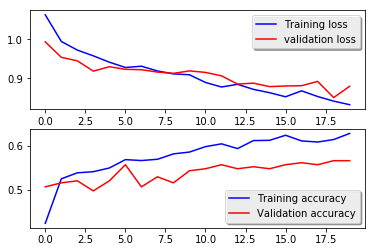

In [318]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [324]:
model.evaluate(X_train,Y_train, batch_size=2)

1956/1969 [============================>.] - ETA: 0s

[0.79609333510747593, 0.65159979685119351]

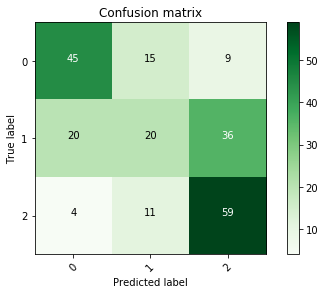

In [319]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [325]:
model.evaluate(X_test,Y_test, batch_size=2)

210/219 [===========================>..] - ETA: 0s

[0.88018160500482878, 0.56621004566210043]

In [326]:
print(classification_report(Y_true, Y_pred_classes))

             precision    recall  f1-score   support

          0       0.65      0.65      0.65        69
          1       0.43      0.26      0.33        76
          2       0.57      0.80      0.66        74

avg / total       0.55      0.57      0.54       219



### Validation Data

In [328]:
encoder = LabelEncoder()
encoder.fit(labels_val)
labels_val = encoder.transform(labels_val)

Y_val = to_categorical(labels_val, num_classes=3)

In [329]:
len(Y_val)

148

In [330]:
x_val = x_val/255.0

In [331]:
len(x_val)

148

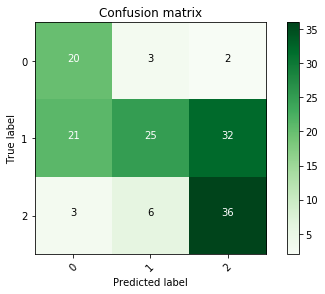

In [332]:
Y_pred_val = model.predict(x_val)
Y_pred_classes = np.argmax(Y_pred_val,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [333]:
model.evaluate(x_val, Y_val, batch_size=2)

136/148 [==========================>...] - ETA: 0s

[0.89951013552175985, 0.54729729729729726]

In [334]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

             precision    recall  f1-score   support

          0       0.45      0.80      0.58        25
          1       0.74      0.32      0.45        78
          2       0.51      0.80      0.63        45

avg / total       0.62      0.55      0.52       148



# Results

### Network structure.
I got the best result using 3 convolutional layers, 3 pooling layers, and 2 fully connected layers. I also include 2 "Dropout" to prevent overfittiong:

* Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,3))
* MaxPool2D(pool_size=(2,2)

* Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu')
* model.add(MaxPool2D(pool_size=(2,2))

* Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu')
* MaxPool2D(pool_size=(2,2)

* Dropout(0.2)

* Flatten()
* Dense(32, activation='relu')
* Dropout(0.1)
* Dense(3, activation = "sigmoid")



I tried some diferent networks structure - different number of layeres (1-3), number of filters (4 - 64) and filter sizes (3*3 - 8*8), different number of nodes for fully connedted layeres. I realized that small number of fulters gives us underfitting. 

### The training and testing results
During the training I used a testing set to validate the accuracly of the model. Testing and training sets have about same number of images for every type of cancer. Some of images were dublicated since I wanted to have roungly same number of images for every class. 

|            | loss | accuracy  
| ------------- | ------------- |----------------
| training  | 0.796  | 0.652 
| testing   | 0.880  | 0.566 
|hold out validation set | 0.899 | 0.547

### Possible improvements 

1. I used Flatten() between the last convolution layer and the first fully connected layer. But when we are flattening the result from convolution, we lose spatial information. It could be great to illuminate flattening. 

2. Use more sophisticated image preprocessing. The images have very different shapes. Also, a lot of image have large black "background". It could be great to select only "informative" part from all images. 

3. Get more data, use better resolution, and add more convolutional layers! I have only 4 GB memory and I am not able to download additional training samples. Thus, I decided to use low resolution (64 by 64) and only 3 layers to prevent overfitting. 

## Conclusion

CNN works well for this type of problem. It is very computational effective. When I tried to use DNN I was able to use only black/withe images and 1 hidden layer. 

Also, I like that CNN prevent spatial information - every kernel "looks" at a part of image, not just a flat array.